# In this notebook, the first part is for LP estimations, the second part is for Deep Neural Networks

# Code for creating m-height 
### NOTE: the following code uses the LP to find m-height

In [27]:
import torch
import itertools
import numpy as np
from scipy.optimize import linprog





def compute_m_height(G, m):
    k, n = G.shape
    print('n ',n)
    assert m <= n - k, "m must be at most n - k"
    
    # Ensure G is systematic
    I_k = np.eye(k)
    assert np.allclose(G[:, :k], I_k), "G must be systematic (first k columns should form an identity matrix)"
    
    indices = list(range(n)) #### [n> --> for any positive integer n
    Psi = list(itertools.product([-1, 1], repeat=m))  # Set of all binary vectors of length m
    
    best_height = -np.inf
    s = 0
    for a, b in itertools.permutations(indices, 2):#permutations(indices, 2):
        X_candidates = [set(comb) for comb in itertools.combinations(set(indices) - {a, b}, m - 1)] # combinations
        # print('a ',a)
        # print('b ', b)
        for X in X_candidates:
            Y = set(indices) - X - {a, b}
            # print('Y ', Y)
            # print('X ', X)
            for psi in Psi:
                tau = [a] + sorted(X) + [b] + sorted(Y)
                # print('tau ', tau)
                tau_inv = {xj: j for j, xj in enumerate(tau)}  # Calculate tau^{-1}
                # for i in range(k):
                #     print(psi[i])
                c = np.array([psi[0] * G[i, a] for i in range(k)])  # Update objective function

                A = []
                b_ineq = []

                for j in X:
                    # row = [(psi[list(X).index(j)] * G[i, tau_inv[j]] - psi[0] * G[i, a]) for i in range(k)]
                    row = [(psi[tau_inv[j]] * G[i, j] - psi[0] * G[i, a]) for i in range(k)]
                    # row = [( - psi[tau_inv[j]] * G[i, j] + psi[0] * G[i, a]) for i in range(k)]
                    A.append(row)
                    b_ineq.append(0)

                    # row_neg = [-psi[list(X).index(j)] * G[i, tau_inv[j]] for i in range(k)]
                    row_neg = [-psi[tau_inv[j]] * G[i, j] for i in range(k)]
                    # row_neg = [psi[tau_inv[j]] * G[i, j] for i in range(k)]
                    A.append(row_neg)
                    b_ineq.append(-1)
                    # b_ineq.append(1)

                for j in Y:
                    # A.append([G[i, tau_inv[j]] for i in range(k)])  # Correctly index using tau_inv
                    A.append([G[i, j] for i in range(k)])  # Correctly index using tau_inv
                    b_ineq.append(1)
                    # b_ineq.append(-1)

                    A.append([-G[i, j] for i in range(k)])
                    b_ineq.append(1)
                    # b_ineq.append(-1)

                A_eq = [[G[i, b] for i in range(k)]]
                b_eq = [1]
                # b_eq = [-1]

                res = linprog(-c, A_ub=A, b_ub=b_ineq, A_eq=A_eq, b_eq=b_eq, method='highs')

                s += 1

                if res.success:
                    best_height = max(best_height, -res.fun)
    # print(s)
    return best_height if best_height != -np.inf else None



In [28]:
# # Example Usage:
G = np.array([[1, 0, 0.4759809, 0.993823, 0.819425], 
              [0, 1, -0.8960798 , -0.7442706, 0.3345122]])  # Systematic generator matrix

# G = np.array([[1, 0, 0.534, 0.583, -0.709, -0.053, 0.543, 0.927], 
#               [0, 1, 0.611 , -1.211, 0.233, -0.784, -0.659, -0.947]])  # Systematic generator matrix
m = 2
print("m-height:", compute_m_height(G, m))

n  5
m-height: 1.9242383477894285


# Code for DNNs

# Required packages for the model

In [ ]:
import torch
import numpy as np
import joblib

from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import time

# loading the dataset $\rightarrow$ this was used for training

In [ ]:
path = "D:\\TAMU\\courses\\spring 2025\\deep learning\\project\\New folder\\"
s_inds = np.load(path+'inds_small_dset.npy')
df = joblib.load(path + "results_dataframe.pkl")


# Class for creating the dataset for dataloader + function for preprocessing the data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

def pre_process_data(gen_mats, nfeat = 1): # matrix of shape [n_samples, n_dims]
    struct_mat = []
    m = nn.AdaptiveAvgPool1d(nfeat)
    for item in gen_mats:
        if type(item) == np.ndarray:
            item = torch.tensor(item.astype(float))
        # if type(item) == torch.Tensor:
        #     continue
        item = item.unsqueeze(0)
        struct_mat.append(m(item))
        
    return torch.cat((struct_mat))

# creating the modified datset 

In [ ]:
print('Getting targets, integers (n,k,m), and the modified matrices (all matrices will have the same number of features)')
target_vals = torch.tensor(df['result'].values)
nkm_vals = torch.tensor(df[['n','k','m']].values)
gmat_vals = pre_process_data(df['P'], nfeat=17)

print('Creating the modified features....')
modif_data = torch.cat([gmat_vals, nkm_vals], axis = 1)


# saving the modified dataset (to avoid loading the big dataset again)

In [ ]:
torch.save(modif_data, 'modif_data_all.pt')
torch.save(target_vals, 'target_vals_all.pt')

# Getting test datset indices (denoted as the small dataset)

In [ ]:
inds_dict = {}
s = 0
for m in df['m'].unique():
    for n in df['n'].unique():
        for k in df['k'].unique():
            l = len(df[(df['m']==m) & (df['n']==n) & (df['k'] == k)])
            if l != 0:
                key = str(m)+'-'+str(n)+'-'+str(k)
                inds_dict[key] = df[(df['m']==m) & (df['n']==n) & (df['k'] == k)].index
                print('m-n-k: ', str(m)+'-'+str(n)+'-'+str(k))
                s+=1

small_dset_per_state = 50000
inds_small_dset = []
for item in inds_dict:
    sampled_inds = np.random.choice(inds_dict[item], size=small_dset_per_state, replace=False)
    inds_small_dset.append(sampled_inds)

inds_small_dset = np.array(inds_small_dset).reshape(-1)


path = "D:\\TAMU\\courses\\spring 2025\\deep learning\\project\\New folder"
np.save(path + 'inds_small_dset', inds_small_dset)

# loading the modified dataset 

In [ ]:
target_vals = torch.load('target_vals_all.pt')
modif_data = torch.load('modif_data_all.pt')


s_inds = np.load('inds_small_dset.npy')
all_inds = range(len(target_vals))
tr_val_inds = np.delete(all_inds, s_inds)
ts_inds = s_inds

print(f'train-val dataset size: {len(tr_val_inds)}')
print(f'test dataset size: {len(ts_inds)}')

# creating train/validation/test dataset

In [ ]:
train_data, val_data, train_targets, val_targets = train_test_split(modif_data[tr_val_inds], target_vals[tr_val_inds], test_size=0.2, random_state=42)
test_data, test_targets = modif_data[ts_inds], target_vals[ts_inds]

inds = np.where(train_targets < 0.5*1e9) # removing very large values ---> can be outliers
train_data, train_targets = train_data[inds], train_targets[inds]

# models

An explanation for the model:
Generally, the model consists of 3 components: 
- An encoder 
- - encoder itself contains 2 calls to the simple encoder which maps modified matrices (17 features in this code) and the \[n,m,k\], each to a 10 dimensional feature vector (hence, after concatanation, the input to the first conv1d layer is 20 dimensional)
- - encoder also utilizes  3 conv1d layers with max pooling
- A Normalizing flow module (where I used planar flows for the trained model with 10 flows)
- A decoder: similar to the encoder, without the use of simple encoders 

### NOTE: the complete model is provided in VAEWithFlow class 

### NOTE: the model predicts log2($\cdot$)

In [ ]:
class simple_encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, 2)
        self.fc2 = nn.Linear(2, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, z):
        o = self.fc1(z)
        o = self.relu(o)
        o = self.fc2(o)
        return o
    


# Planar Flow
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim))
        self.u = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.randn(1))
    
    def forward(self, z):
        linear = torch.matmul(z, self.w.T) + self.b
        activation = torch.tanh(linear)
        psi = (1 - activation ** 2) * self.w
        det_jacobian = torch.abs(1 + torch.matmul(psi, self.u.T))
        log_det = torch.log(det_jacobian + 1e-6)
        z_next = z + self.u * activation
        return z_next, log_det

# Radial Flow
class RadialFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.z0 = nn.Parameter(torch.randn(1, dim))
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))
        self.dim = dim
    
    def forward(self, z):
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (1 + r)
        beta_h = self.beta * h
        z_next = z + beta_h * (z - self.z0)
        log_det = (self.dim - 1) * torch.log(1 + beta_h) + torch.log(1 + beta_h + self.beta * h**2)
        return z_next, log_det

# Normalizing Flow Model
class NormalizingFlow(nn.Module):
    def __init__(self, dim, num_flows=2, flow_type='planar'):
        super().__init__()
        self.flows = nn.ModuleList([PlanarFlow(dim) if flow_type == 'planar' else RadialFlow(dim) for _ in range(num_flows)])
    
    def forward(self, z0):
        log_det_sum = 0
        z = z0
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_sum += log_det
        return z, log_det_sum

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        self.emnk = simple_encoder(input_dim = 3, output_dim = 10)
        self.eg = simple_encoder(input_dim = input_dim - 3, output_dim = 10)
    
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 2, padding = 1)
        self.pool1 = nn.MaxPool1d(kernel_size = 2)
        self.conv2 = nn.Conv1d(in_channels = 16, out_channels = 64, kernel_size = 2, padding = 1) # was 32 previously - was 3 previously
        self.pool2 = nn.MaxPool1d(kernel_size = 2)
        self.conv3 = nn.Conv1d(in_channels = 64, out_channels = 256, kernel_size = 2, padding = 1) # was 128 previously
        self.pool3 = nn.MaxPool1d(kernel_size = 2)
        
        self.flatten = nn.Flatten()
        
        
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc1 = nn.Linear(32*5, 64)
        self.fc1 = nn.Linear(256*3, 64) # 128 * 2 previously
        self.fc2 = nn.Linear(64, 64)
        self.mu = nn.Linear(64, latent_dim)
        self.log_var = nn.Linear(64, latent_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        f1 = self.emnk(x[:,-3:])
        f2 = self.eg(x[:,:-3])
        f = torch.cat([f1,f2], axis = 1)
        
        f = f.unsqueeze(1)
        
        h = self.conv1(f)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.pool2(h)
        h = self.conv3(h)
        h = self.pool3(h)
        h = self.flatten(h)
#         print(h.shape)
        
        h = self.fc1(h)
        h = self.relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h)


        mu = self.mu(h)
        log_var = self.log_var(h)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0, mu, log_var

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.out = nn.Linear(64, output_dim)
    
    def forward(self, z):
        h = self.fc1(z)
        h = self.relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h) ### the following layer was not previously there....
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h)

        o = self.out(h)
        return self.relu(o) # o if output is normalized, so it can be positive and # relu(o) output must be positive 

# Full VAE + Flow Model
class VAEWithFlow(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, num_flows=2, flow_type='planar'):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.flow = NormalizingFlow(latent_dim, num_flows, flow_type)
        self.decoder = Decoder(latent_dim, output_dim)
        self.latent_dim = latent_dim
    
    def forward(self, x):
        z0, mu, log_var = self.encoder(x)
        z_k, log_det = self.flow(z0)
        x_recon = self.decoder(z_k)
        return x_recon, z_k, mu, log_var, log_det
    
    def sample(self, num_samples=1):
        z0 = torch.randn(num_samples, self.latent_dim)
        z_k, _ = self.flow(z0)
        return self.decoder(z_k)




# Creating data loaders 
### NOTE: I did not get good performance with normalization, so I just restricted the model to predict the log2(m=height)
### NOTE: Targets in train loader already are log2(m-height), however for validation and test dataset, I used the m-heights themselves

In [ ]:

train_dataset = CustomDataset(torch.tensor(train_data), torch.log2(torch.tensor(train_targets)))
valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
test_dataset = CustomDataset(torch.tensor(test_data), torch.tensor(test_targets))




batch_size = 1024 * 1 #256 * 4
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers = num_workers)  # Shuffle only for training data
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)


# Model specifications


In [ ]:

input_dim = 20#13
latent_dim = 2#4#5
output_dim = 1
num_flows = 10#10#4
num_epochs = 100
flow_type = 'planar'  # Choose 'planar' or 'radial'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# scaler = GradScaler()

model = VAEWithFlow(input_dim, latent_dim, output_dim, num_flows, flow_type).to(torch.float64).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=1e-5)

model

# training 

In [ ]:
bperf = torch.inf
p_var = torch.tensor(0.2)
model.train()
eps = 1e-5
scale_kl = 1e-4
tr_loss_track, val_loss_track = [],[]
tr_loss_all, val_loss_all, tr_kl_all, mse_all= [],[],[],[]
for epoch in range(num_epochs):
    total_loss = 0
    t_start = time.time()
    
    step = 0
    for x,y in train_loader:
        optimizer.zero_grad()
        x,y = x.to(device), y.to(device) # ---> log2 y (in train loader we have log2 y)
        y_hat, z_k, mu, log_var, log_det = model(x) # ---> log2 y hat (model is forced to predict log2 y)


        ### although it was enought to find only the mse of y and y_hat (since both of them are log2(.)), 
        ### but the following loss performed better empirically (I might be wrong however)
        loss = torch.log2(( (y+eps)/(y_hat.squeeze(-1)+eps) )) ** 2 
        loss = loss.mean()
        
        ### this mse is just for checking the model's performance --> it was not used in updating the model
        mse = F.mse_loss( y, y_hat.squeeze(-1))

        ### scaling the loss for putting more weight on the accuracy of the model 
        new_loss = 10 * loss 

        ### kl divergence loss for Normalizing Flow part which is optimized by elbo (similar loss as VAE)
        ### kl divergence is scaled which is a common practice, and helps the model to converge faster
        kl_div = ((mu-0)**2 + p_var**2)/(2*torch.exp(log_var)) + log_var - math.log(p_var) - 0.5
        elbo_loss = new_loss + scale_kl * kl_div.mean() #+ mse
        elbo_loss.backward()
                

        optimizer.step()        
        total_loss += loss.item()

        ### keeping track of different losses
        tr_kl_all.append(kl_div.mean().item())
        tr_loss_all.append(loss.item())
        mse_all.append(mse.item())
        
        step += 1
        print(f'step {step}/{len(train_loader)}, loss: {loss.item()}, mse_all: {mse_all[-1]}', end = '\r')

    tr_loss_track.append(total_loss/len(train_loader))
    # print(f'Epoch: {epoch}, Train error: {tr_loss_track[-1]}')

    ### Validating the model 
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in valid_loader:
            x_val,y_val = x_val.to(device), y_val.to(device)
            y_hat, z_k, mu, log_var, log_det = model(x_val) # ---> log y hat

            y_val = torch.log2(y_val) # ---> since the model predicts the log2 y , and the validation y is not on log 
            
            ### again, for consistency, similar loss as in training is utilized 
            val_loss = F.mse_loss( torch.log2(((y_val + eps))), torch.log2((y_hat.squeeze(-1) + eps)))
            total_val_loss += val_loss.item()
            val_loss_all.append(val_loss.item())
        
    
    total_val_loss /= len(valid_loader)
    scheduler.step()

    val_loss_track.append(total_val_loss)
    
    ### saving the loss track
    np.save('vaenf_kl_loss_all.npy', np.array(tr_kl_all))
    np.save('vaenf_val_loss_track.npy', np.array(val_loss_track))
    np.save('vaenf_tr_loss_track.npy', np.array(tr_loss_track))
    
    if total_val_loss < bperf: 
        bperf = total_val_loss
        torch.save(model.state_dict(), 'vaenf_best_perf_model.pth')
    e_time = time.time()
    if epoch%1 == 0:
            print(f"Epoch {epoch+1}, train Loss: {total_loss / len(train_loader)}, valid loss: {total_val_loss}, lr: {scheduler.get_last_lr()}, time: {e_time-t_start}")




# Loading the best saved model

In [ ]:
checkpoint = torch.load('vaenf_best_perf_model.pth', map_location=torch.device(device)) 
model.load_state_dict(checkpoint)

/var/folders/tm/y775skms6473dvdtkt3t59n80000gn/T/ipykernel_8670/2518314598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('vaenf_best_perf_model

<All keys matched successfully>

# Plotting the performance on training loss and validation

### IMPORTANT NOTE: since I saved the loss from an alternative loss function, i.e., log2( y/yhat )**2 in which both y and yhat are log2($\cdot$), even though I am plotting the $2^{val/train-loss}$, it is a bit different from $($ log2(ground-truth)-log2(prediction)$)^2$. However, as it can be seen from the validation performance, the model did not overfit.

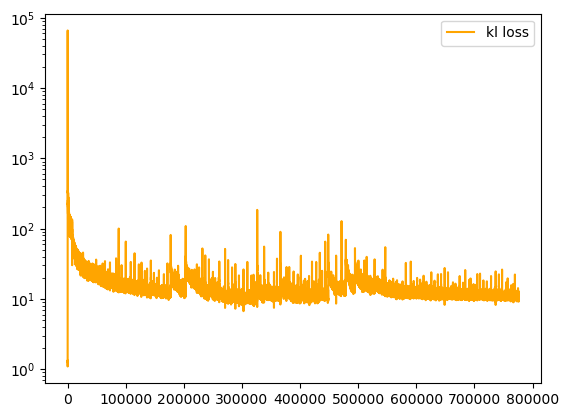

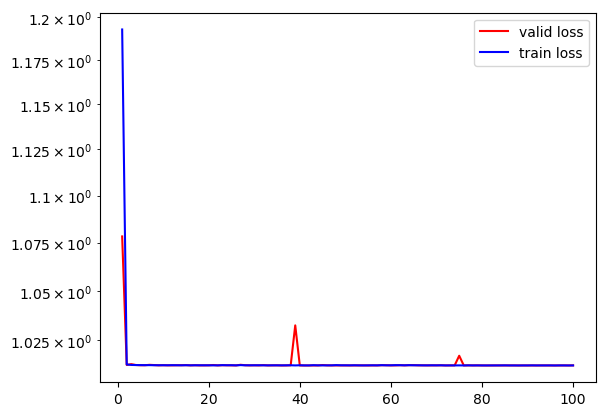

In [22]:
val_track = np.load('vaenf_val_loss_track.npy')
tr_track = np.load('vaenf_tr_loss_track.npy')
kl_track = np.load('vaenf_kl_loss_all.npy')
# val_track = np.array(val_loss_track)# * len(valid_loader)
# tr_track = np.array(tr_loss_track)

plt.plot(kl_track, label = 'kl loss', color = 'orange')
plt.yscale('log')
plt.legend()


plt.figure()
plt.plot(range(1,len(val_track)+1),2**val_track[:], label = 'valid loss', color = 'red')
plt.plot(range(1,len(val_track)+1),2**tr_track[:], label = 'train loss', color = 'blue')
# plt.plot(kl_track, label = 'kl loss', color = 'orange')
plt.yscale('log')
# plt.xscale('log')
plt.legend()


# Testing the model on the test dataset
### in the following code, since the model is stochastic, I run the model 3 times and report the average error with its standard deviation
### NOTE: in the following code, I am reporting the MSE(log2(ground-truth) , log2(predictions)). 

In [23]:
eps = 1e-5
model.eval()
total_test_loss = 0
with torch.no_grad():
    sampled_err = []
    for ns in range(3):
        xs = []
        y_preds = []    
        ys = []
        for x_test, y_test in test_loader:
            x_test,y_test = x_test.to(device), y_test.to(device)
            y_hat, z,m,lv,ld = model(x_test) # ---> log2 y
            y_preds.append(y_hat.squeeze(1))
            ys.append(torch.log2(y_test))
            xs.append(x_test[:,-1])
            test_loss = F.mse_loss( torch.log2((y_test + eps)), (y_hat.squeeze(-1)))
            # test_loss = F.mse_loss( torch.log2((torch.log2(y_test) + eps)), torch.log2(y_hat.squeeze(-1) + eps))
            total_test_loss += test_loss.item()

        total_test_loss /= len(test_loader)

        sampled_err.append(total_test_loss)
sampled_err = np.array(sampled_err)
print(f'Error mean: {sampled_err.mean()} \nError std: {sampled_err.std()}')

Error mean: 1.368897588191137 
Error std: 0.0007343444610409931


# plotting the test data predictions VS the ground truth
### NOTE: as it can be seen in the following, the spread of predictions are off wrt the ground truth. This observation raise the question if we can use a post-training method to map the predictions to a wider region or not? the other question is that how can we encourage a wider prediction range in our model. 

### NOTE: the other problem might be due the imbalanced dataset (higher values might be seen much less frequent). In that sense, we might consider some penalty for larger values / errors

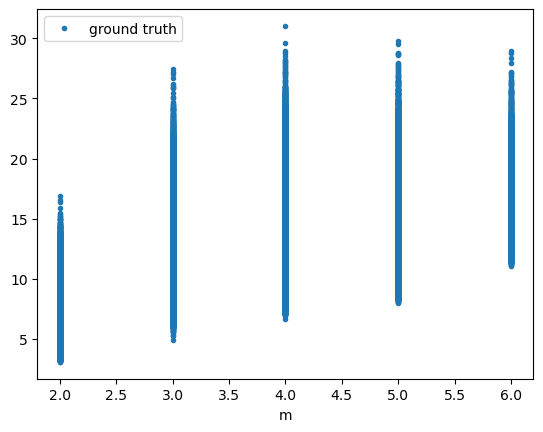

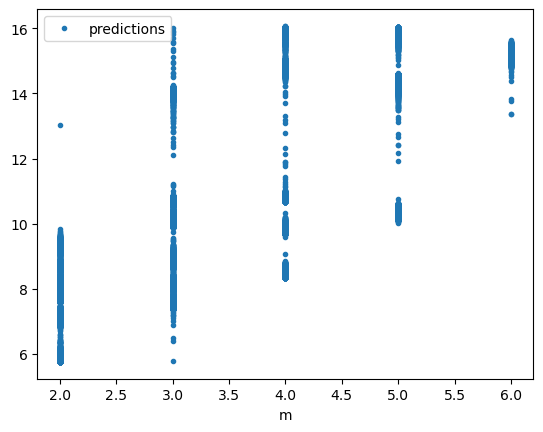

In [18]:
ypreds_test = torch.cat(y_preds,dim=0).detach().cpu()
ygt = torch.cat(ys).detach().cpu()
x = torch.cat(xs).detach().cpu()

plt.plot(x, ygt, '.', label = 'ground truth')
plt.legend()
plt.xlabel('m')
plt.figure()
plt.plot(x, ypreds_test, '.', label = 'predictions')
plt.xlabel('m')
plt.legend()

# test error for each m

In [20]:
for ms in range(2,7):
    inds = np.where(x == ms)
    print(f'test loss for m={ms}: ', ((ygt[inds]-ypreds_test[inds])**2).mean())

test loss for m=2:  tensor(0.3903, dtype=torch.float64)
test loss for m=3:  tensor(0.9790, dtype=torch.float64)
test loss for m=4:  tensor(1.8162, dtype=torch.float64)
test loss for m=5:  tensor(2.6397, dtype=torch.float64)
test loss for m=6:  tensor(3.4999, dtype=torch.float64)


# creating the function for the template 

In [ ]:
!pip install tamu_csce_636_project1

# Please use the following function for evaluating the model

In [ ]:
def ready_to_use_func(n,k,m,p_list, path = 'vaenf_best_perf_model.pth'): ## please save the model where ever you are using the function

    #### loading the model 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VAEWithFlow(input_dim=20, latent_dim=2, output_dim=1, num_flows=10, flow_type='planar').to(torch.float64).to(device)
    model_check_point = torch.load(path)
    model.load_state_dict(model_check_point)    

    nmks = torch.tensor([[n,m,k] for item in p_list])

    p_list_tensor = torch.tensor(p_list) ### following the instrunctions in the template
    p_list_tensor = p_list_tensor.reshape(-1, p_list_tensor.shape[1] * p_list_tensor.shape[2])
    modif_matrices = pre_process_data(p_list_tensor, nfeat=17)
    
    modif_features = torch.cat([modif_matrices, nmks], axis = 1)
    modif_features = modif_features.to(device).to(torch.float64)

    output = model(modif_features)
    output = 2 ** output ### my model predicts the log2
    return output.flatten().tolist()


# NOTE: alternatively, if one wants to use (log2(m) - log2(mhat))**2, they can use the following piece of code (which is almost exactly the same as the previous code, with the differnce in loss function)
## to showcase the model is being trained with the following loss, I let the model to be trained for 15 epochs 

In [ ]:
bperf = torch.inf
p_var = torch.tensor(0.2)
model.train()
eps = 1e-5
scale_kl = 1e-4
tr_loss_track, val_loss_track = [],[]
tr_loss_all, val_loss_all, tr_kl_all, mse_all= [],[],[],[]
for epoch in range(num_epochs):
    total_loss = 0
    t_start = time.time()
    
    step = 0
    for x,y in train_loader:
        optimizer.zero_grad()
        x,y = x.to(device), y.to(device) # ---> log2 y (in train loader we have log2 y)
        y_hat, z_k, mu, log_var, log_det = model(x) # ---> log2 y hat (model is forced to predict log2 y)


        
        loss = (( (y+eps)-(y_hat.squeeze(-1)+eps) )) ** 2 
        loss = loss.mean()
        
        ### this mse is just for checking the model's performance --> it was not used in updating the model
        mse = F.mse_loss( y, y_hat.squeeze(-1))

        ### scaling the loss for putting more weight on the accuracy of the model 
        new_loss = 1 * loss 

        ### kl divergence loss for Normalizing Flow part which is optimized by elbo (similar loss as VAE)
        ### kl divergence is scaled which is a common practice, and helps the model to converge faster
        kl_div = ((mu-0)**2 + p_var**2)/(2*torch.exp(log_var)) + log_var - math.log(p_var) - 0.5
        elbo_loss = new_loss + scale_kl * kl_div.mean() #+ mse
        elbo_loss.backward()
                

        optimizer.step()        
        total_loss += loss.item()

        ### keeping track of different losses
        tr_kl_all.append(kl_div.mean().item())
        tr_loss_all.append(loss.item())
        mse_all.append(mse.item())
        
        step += 1
        print(f'step {step}/{len(train_loader)}, loss: {loss.item()}, mse_all: {mse_all[-1]}', end = '\r')

    tr_loss_track.append(total_loss/len(train_loader))
    # print(f'Epoch: {epoch}, Train error: {tr_loss_track[-1]}')

    ### Validating the model 
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in valid_loader:
            x_val,y_val = x_val.to(device), y_val.to(device)
            y_hat, z_k, mu, log_var, log_det = model(x_val) # ---> log y hat

            y_val = torch.log2(y_val) # ---> since the model predicts the log2 y , and the validation y is not on log 
            
            
            val_loss = F.mse_loss( (((y_val + eps))), ((y_hat.squeeze(-1) + eps)))
            total_val_loss += val_loss.item()
            val_loss_all.append(val_loss.item())
        
    
    total_val_loss /= len(valid_loader)
    scheduler.step()

    val_loss_track.append(total_val_loss)
    
    ### saving the loss track
    # np.save('vaenf_kl_loss_all.npy', np.array(tr_kl_all))
    # np.save('vaenf_val_loss_track.npy', np.array(val_loss_track))
    # np.save('vaenf_tr_loss_track.npy', np.array(tr_loss_track))
    
    if total_val_loss < bperf: 
        bperf = total_val_loss
        # torch.save(model.state_dict(), 'vaenf_best_perf_model.pth')
    e_time = time.time()
    if epoch%1 == 0:
            print(f"Epoch {epoch+1}, train Loss: {total_loss / len(train_loader)}, valid loss: {total_val_loss}, lr: {scheduler.get_last_lr()}, time: {e_time-t_start}")




Epoch 1, train Loss: 3.6295547679455917, valid loss: 1.8605748872070678, lr: [0.00099], time: 370.3649160861969
Epoch 2, train Loss: 1.4721071794934657, valid loss: 1.4758994031668915, lr: [0.0009801], time: 380.45856165885925
Epoch 3, train Loss: 1.449204452275194, valid loss: 1.448467466291079, lr: [0.000970299], time: 374.4647614955902
Epoch 4, train Loss: 1.451385832578848, valid loss: 1.510777408948184, lr: [0.0009605960099999999], time: 378.2787449359894
Epoch 5, train Loss: 1.4445426700451889, valid loss: 1.4467272164737275, lr: [0.0009509900498999999], time: 368.8771550655365
Epoch 6, train Loss: 1.4465726855766965, valid loss: 1.482673881128157, lr: [0.0009414801494009999], time: 369.1657557487488
Epoch 7, train Loss: 1.4443926183625997, valid loss: 1.4486190155389782, lr: [0.0009320653479069899], time: 370.8797733783722
Epoch 8, train Loss: 1.442852929681374, valid loss: 1.4447470530492943, lr: [0.00092274469442792], time: 370.4596297740936
Epoch 9, train Loss: 1.451838629497

KeyboardInterrupt: 

# LP Estimations and Deep Neural Networks

## Overview
This repository contains a Jupyter Notebook divided into two main parts:

1. **Linear Programming (LP) Estimations** – Setup and estimation tasks using LP methods.  
2. **Deep Neural Networks (DNNs)** – Implementation of a neural architecture with normalizing flows.

---

## Model Description

### Encoder
- Two **simple encoders**:
  - Each maps modified matrices (17 features) and the tuple [n, m, k] into a **10-dimensional feature vector**.  
  - After concatenation, the input to the first Conv1D layer is **20-dimensional**.  
- Includes **3 Conv1D layers** with **max pooling**.

### Normalizing Flow Module
- Uses **planar flows**.  
- The trained model employs **10 flow layers**.

### Decoder
- Mirrors the encoder structure.  
- Does **not** use simple encoders.

---

## Implementation
The complete model is implemented in the class:

```python
VAEWithFlow




# LP Estimations and Deep Neural Networks

## Overview
This repository contains a Jupyter Notebook divided into two main parts:

1. **Linear Programming (LP) Estimations** – Setup and estimation tasks using LP methods.  
2. **Deep Neural Networks (DNNs)** – Implementation of a neural architecture with normalizing flows.

---

## Model Description

### Encoder
- Two **simple encoders**:
  - Each maps modified matrices (17 features) and the tuple [n, m, k] into a **10-dimensional feature vector**.  
  - After concatenation, the input to the first Conv1D layer is **20-dimensional**.  
- Includes **3 Conv1D layers** with **max pooling**.

### Normalizing Flow Module
- Uses **planar flows**.  
- The trained model employs **10 flow layers**.

### Decoder
- Mirrors the encoder structure.  
- Does **not** use simple encoders.

---

## Implementation
The complete model is implemented in the class:

<!-- python -->
VAEWithFlow


This integrates:
- Encoder  
- Normalizing Flow module  
- Decoder  

---

## Output
The model predicts values in the form:

\[
\log_2(\cdot)
\]

---

## Notes
- Part 1: LP estimations for baseline tasks.  
- Part 2: Deep Neural Network training using the `VAEWithFlow` model.  
- The architecture is modular and can be extended for different input dimensions or flow configurations.  
- Saved models can be found in the `notebook` and `model` directories.  
- Loss tracks can be found in the `loss tracks` directory.  